# Cutaneous Vs. Mucosal analysis

##### 1. Melanoma association with clusters analysis - 
Each cluster see the number of cells correspond to cutaneous patients vs. number of cells corespond to mucosal patients.

##### 2. GEP association with melanoma -
Per program, take all usage values of cells coming from cutaneous patients vs. mucosal patients, and perform Wilcoxon ranksum test.

##### 3. GEP association with melanoma (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between cutaneous and mucosal patients.


In [2]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats


Helper functions:

In [3]:
def print_pvals(pvals, n_groups):
    plt.figure(figsize=(8, 6), dpi=80);

    small_pvals = pvals[pvals[:,1]<0.05]
    big_pvals = pvals[pvals[:,1]>=0.05]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[0.05,0.05], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([0.05, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));
        
def get_coorected_label(x ,p_value_dic):
    pvalue = p_value_dic[x]
    return str(x) + '\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if pvalue < sig])

def save_pvals(path, pvals, corrected_pvals, GROUP_NAME):
    pval_df = pd.DataFrame(np.array([pvals[:,0], pvals[:,1], corrected_pvals[:,1]]).T, columns=[GROUP_NAME, 'pval', 'corrected_pval'])#.sort_values('pval')
    pval_df[GROUP_NAME] = pval_df[GROUP_NAME].astype(int)
    pval_df.to_excel(path, index=False)


### Specify clinical table and set output path
clinical table can be 1|2|3
* 1 - NR mucosal vs NR cutaneous
* 2 - NR mucosal vs R cutaneous
* 3 - NR mucosal vs NR & R cutaneous

OUTPUT PATH - all marker list/heatmaps/figures will be saved there

In [29]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/4.1.22/NR_mucosal_vs_R_AND_NR_cutaneous'
# FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/4.1.22/NR_mucosal_vs_NR_cutaneous'
CLINICAL_TABLE_NUM = 3

create_folder(FOLDER_PATH)

folder: /storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/4.1.22/NR_mucosal_vs_R_AND_NR_cutaneous has been created


##### Loads clinical table to get labels - Mucosal/Cutaneous

In [30]:
#melanoma_clinical_data = get_clinical_data() #ICI=True, after_biopsy='ICI')
melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM)
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
display(melanoma_clinical_data.head(5))
res_melanoma_clinical_data['Melanoma type'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx
Num of samples in table is 18


,index,Patient id,Melanoma type,response,prior to biopsy,after biopsy,ICI,BRAF
2,2,M99,Mucosal,NR,ICI,other therapy,True,False
9,9,M106,Cutaneous,NR,ICI,other therapy,True,False
10,10,M107,Cutaneous,NR,ICI,other therapy,True,False
14,14,M111,Mucosal,NR,ICI,other therapy,True,False
20,20,M120,Cutaneous,NR,ICI,other therapy,True,True


Cutaneous    14
Mucosal       4
Name: Melanoma type, dtype: int64

#### Builds Mucosal/Cutaneous sample list

In [31]:
cutaneous_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'Cutaneous'].index.tolist()
mucosal_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'Mucosal'].index.tolist()
no_used_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'other'].index.tolist()

print(f'number cutaneous_samples: {len(cutaneous_samples)}')
print(f'number mucosal_samples: {len(mucosal_samples)}')
print(f'number of \'other\' samples: {len(no_used_samples)}')


number cutaneous_samples: 14
number mucosal_samples: 4
number of 'other' samples: 0


#### Loads Mucosal & Cutaneous cohort:

In [106]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl'

cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
immune_cohort = cohort.filter_cells_by_property('is_immune', True)

#  1. Differential expression analysis

(1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

## Tumor -  differential expression analysis

In [107]:
cutaneous_samples_indices = [s in cutaneous_samples for s in tumor_cohort.samples]
mucosal_samples_indices =[s in mucosal_samples for s in tumor_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in tumor_cohort.samples]

print(f'number of cells in cutaneous_samples_indices: {sum(cutaneous_samples_indices)}')
print(f'number of cells in mucosal_samples_indices: {sum(mucosal_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

cutaneous_samples_tumor_cells = tumor_cohort[cutaneous_samples_indices]
mucosal_samples_tumor_cells = tumor_cohort[mucosal_samples_indices]

number of cells in cutaneous_samples_indices: 44564
number of cells in mucosal_samples_indices: 6837
number of cells in no_used_samples_indices: 0


#### Conduct fisher's exact test to find markers of response in tumor cells:

In [108]:
cutaneous_markers = find_marker_genes_in_cluster(cutaneous_samples_tumor_cells, mucosal_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in cutaneous samples: {len(cutaneous_markers)}')

#### Conduct fisher's exact test to find markers of non-response in tumor cells:

In [110]:
mucosal_markers = find_marker_genes_in_cluster(mucosal_samples_tumor_cells, cutaneous_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in mucosal samples: {len(mucosal_markers)}')

#### Builds heatmap:

In [112]:
number_of_markers = 50

In [113]:
# arrange cells indices by mean expression
cutaneous_markers_indices = np.array([tumor_cohort.features.index(f) for f in cutaneous_markers.iloc[:number_of_markers]['features']])
cutaneous_cells_indices = np.flip(np.argsort(cutaneous_samples_tumor_cells.counts[:, cutaneous_markers_indices].mean(axis=1)))

mucosal_markers_indices = [tumor_cohort.features.index(f) for f in mucosal_markers.iloc[:number_of_markers]['features']]
mucosal_cells_indices = np.flip(np.argsort(mucosal_samples_tumor_cells.counts[:, mucosal_markers_indices].mean(axis=1)))

In [114]:
genes_indices = [tumor_cohort.features.index(f) for f in cutaneous_markers.iloc[:number_of_markers]['features']] + [tumor_cohort.features.index(f) for f in mucosal_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([cutaneous_samples_tumor_cells.counts[cutaneous_cells_indices][:, genes_indices], mucosal_samples_tumor_cells.counts[mucosal_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

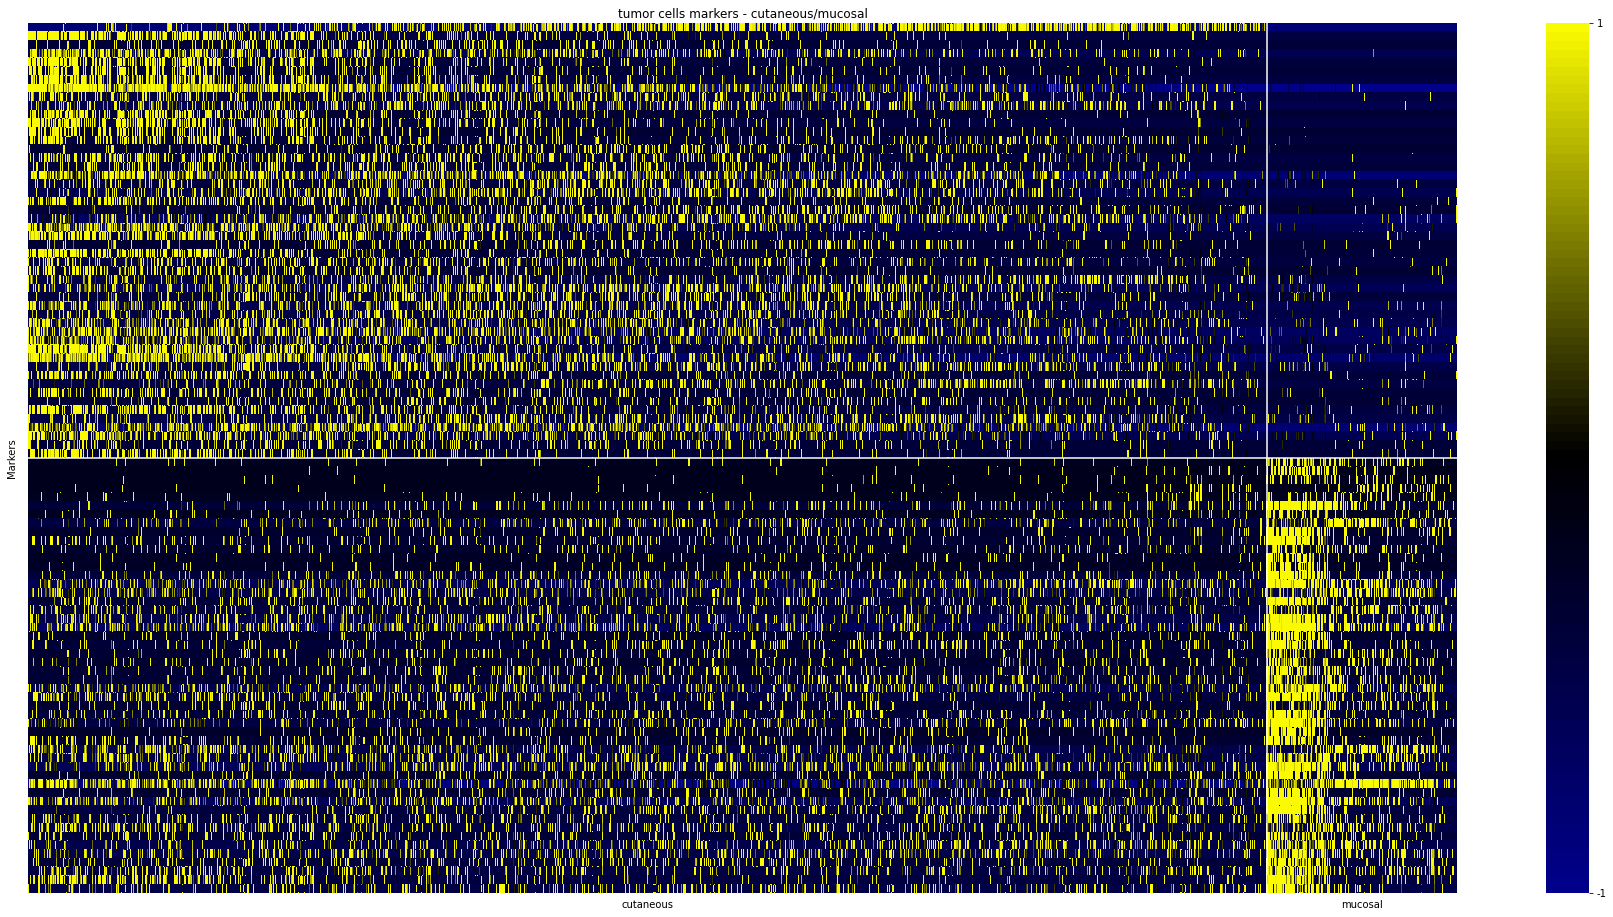

In [115]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/immune/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 5)
fig.set_size_inches(32, 16)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(cutaneous_samples_tumor_cells.number_of_cells/2), cutaneous_samples_tumor_cells.number_of_cells+int(mucosal_samples_tumor_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['cutaneous', 'mucosal'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(cutaneous_samples_tumor_cells.number_of_cells, color='white')
ax.set_title(f"tumor cells markers - cutaneous/mucosal");
# ax.set_xlabel('cutaneous            non-response');
ax.set_ylabel('Markers');

In [116]:
FILE_NAME = r'tumor_cells_marker_heatmap.png'

create_folder(FOLDER_PATH)
fig.savefig(join(FOLDER_PATH, FILE_NAME))
cutaneous_markers.to_excel(join(FOLDER_PATH, r'cutaneous_tumor_markers.xlsx'))
mucosal_markers.to_excel(join(FOLDER_PATH, r'mucosal_tumor_markers.xlsx'))

## Immune - differential expression analysis

In [117]:
cutaneous_samples_indices = [s in cutaneous_samples for s in immune_cohort.samples]
mucosal_samples_indices =[s in mucosal_samples for s in immune_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in immune_cohort.samples]

print(f'number of cells in cutaneous_samples_indices: {sum(cutaneous_samples_indices)}')
print(f'number of cells in mucosal_samples_indices: {sum(mucosal_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

cutaneous_samples_immune_cells = immune_cohort[cutaneous_samples_indices]
mucosal_samples_immune_cells = immune_cohort[mucosal_samples_indices]

number of cells in cutaneous_samples_indices: 24281
number of cells in mucosal_samples_indices: 8475
number of cells in no_used_samples_indices: 0


##### Conduct fisher's exact test to find markers of cutaneous in immune cells:

In [118]:
immune_cutaneous_markers = find_marker_genes_in_cluster(cutaneous_samples_immune_cells, mucosal_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in cutaneous samples: {len(immune_cutaneous_markers)}')

Number of markers found in cutaneous samples: 145


##### Conduct fisher's exact test to find markers of mucosal in immune cells:

In [123]:
immune_mucosal_markers = find_marker_genes_in_cluster(mucosal_samples_immune_cells, cutaneous_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
print(f'Number of markers found in mucosal samples: {len(immune_mucosal_markers)}')

Number of markers found in mucosal samples: 2527


In [132]:
immune_mucosal_markers = immune_mucosal_markers[(immune_mucosal_markers['%expressing_diff']>0.07) & (immune_mucosal_markers['(1)%expressing']>0.1)]

##### Builds heatmap:

number_of_markers = 50

In [135]:
# arrange cells indices by mean expression
immune_cutaneous_markers_indices = np.array([immune_cohort.features.index(f) for f in immune_cutaneous_markers.iloc[:number_of_markers]['features']])
immune_cutaneous_cells_indices = np.flip(np.argsort(cutaneous_samples_immune_cells.counts[:, immune_cutaneous_markers_indices].mean(axis=1)))

immune_mucosal_markers_indices = [immune_cohort.features.index(f) for f in immune_mucosal_markers.iloc[:number_of_markers]['features']]
immune_mucosal_cells_indices = np.flip(np.argsort(mucosal_samples_immune_cells.counts[:, immune_mucosal_markers_indices].mean(axis=1)))

In [136]:
genes_indices = [immune_cohort.features.index(f) for f in immune_cutaneous_markers.iloc[:number_of_markers]['features']] + [immune_cohort.features.index(f) for f in immune_mucosal_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([cutaneous_samples_immune_cells.counts[immune_cutaneous_cells_indices][:, genes_indices], mucosal_samples_immune_cells.counts[immune_mucosal_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

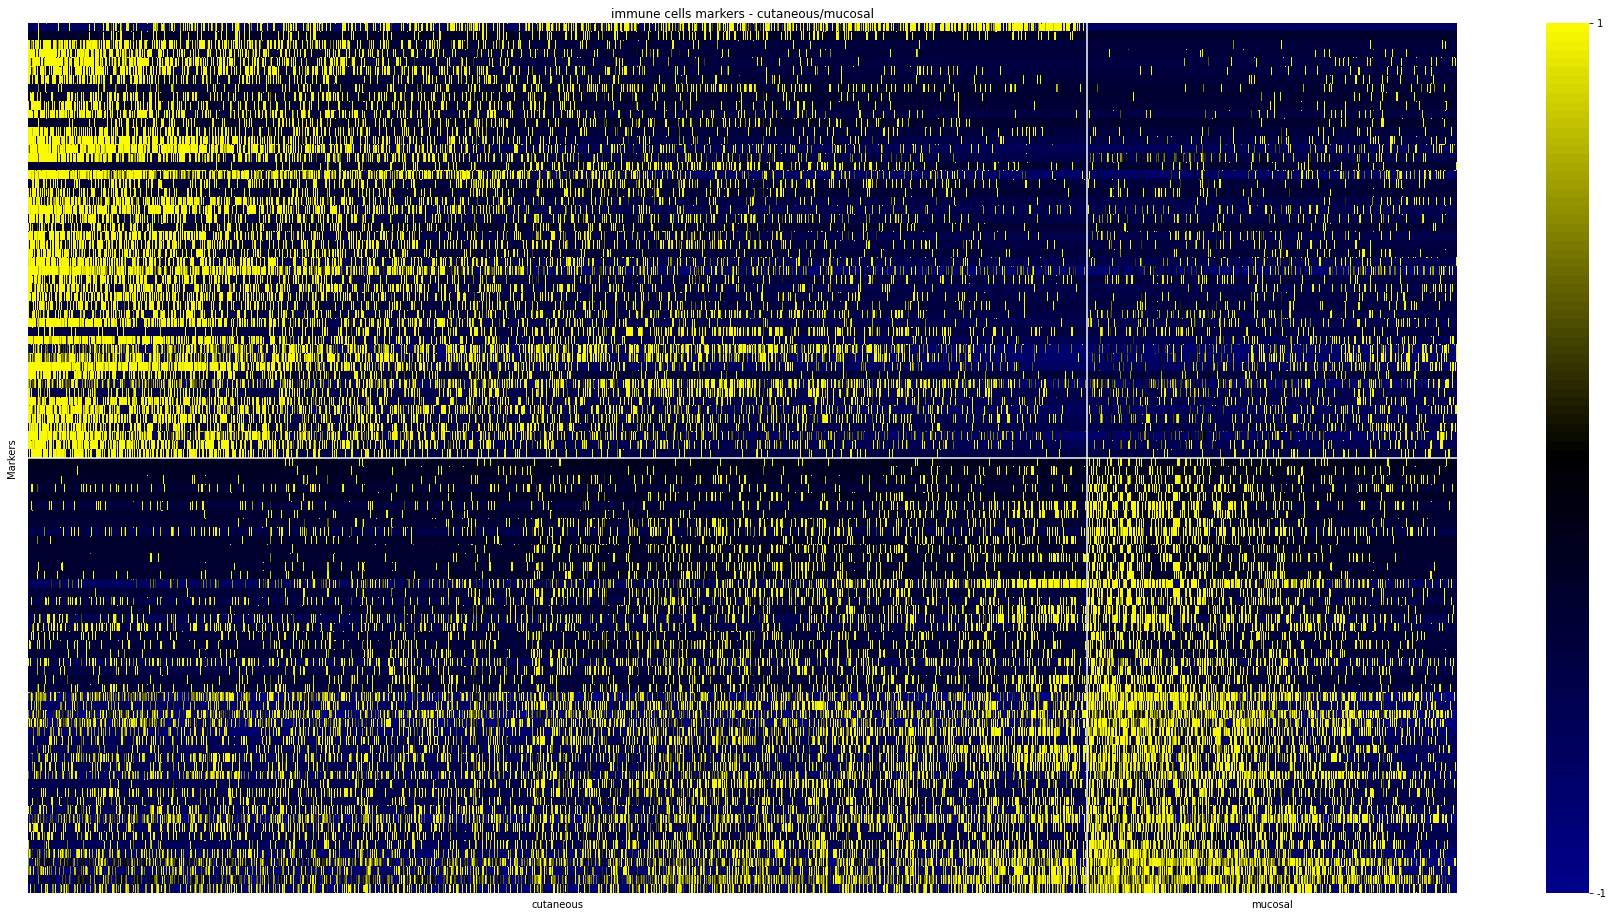

In [137]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/immune/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 5)
fig.set_size_inches(32, 16)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(cutaneous_samples_immune_cells.number_of_cells/2), cutaneous_samples_immune_cells.number_of_cells+int(mucosal_samples_immune_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['cutaneous', 'mucosal'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(cutaneous_samples_immune_cells.number_of_cells, color='white')
ax.set_title(f"immune cells markers - cutaneous/mucosal");
# ax.set_xlabel('cutaneous            non-response');
ax.set_ylabel('Markers');

In [138]:
FILE_NAME = r'immune_cells_marker_heatmap.png'

create_folder(FOLDER_PATH)
fig.savefig(join(FOLDER_PATH, FILE_NAME))
immune_cutaneous_markers.to_excel(join(FOLDER_PATH, r'cutaneous_immune_markers.xlsx'))
immune_mucosal_markers.to_excel(join(FOLDER_PATH, r'mucosal_immune_markers.xlsx'))

# 2. Melanoma association with clusters analysis

Each cluster see the number of cells correspond to cutaneous patients vs. number of cells corespond to mucosal patients.


In [32]:
# clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
# clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/subcohort_1.1.22_run_1.1.22/subcohort_immune_1.1.22_clusters_mapping.csv'

clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

##### Takes only samples that appear in the clinical table

In [33]:
clusters_barcodes_mapping_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df["Sample"].isin(melanoma_clinical_data['Patient id'])]

###### cluster visualizations

In [34]:
df = clusters_barcodes_mapping_df#.drop(columns=['Unnamed: 0'])
df['Melanoma type'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

n_cutaneous = df['Melanoma type'].value_counts()['Cutaneous']
n_mucosal = df['Melanoma type'].value_counts()['Mucosal']

In [35]:
clusters = df['Cluster'].unique()

cutaneous_counts = np.zeros(len(clusters))
mucosal_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    melanoma_type = df[df['Cluster']==cluster]['Melanoma type']
    cutaneous_counts[idx] = sum(melanoma_type=='Cutaneous')
    mucosal_counts[idx] = sum(melanoma_type=='Mucosal')


RanksumsResult(statistic=2.721344205666436, pvalue=0.006501702373081825)
WilcoxonResult(statistic=0.0, pvalue=0.001953125)


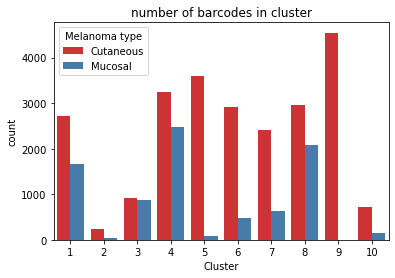

In [36]:

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Melanoma type', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(cutaneous_counts, mucosal_counts))
print(wilcoxon(cutaneous_counts, mucosal_counts))

##### Normalized by group size (number of barcodes in group - Mucosal/Cutaneous):

In [37]:
df = df[df['Melanoma type']!='other']

Normalized by number of barcodes in group (Mucosal/Cutaneous):

RanksumsResult(statistic=0.6047431568147635, pvalue=0.5453496680111236)
WilcoxonResult(statistic=26.0, pvalue=0.921875)


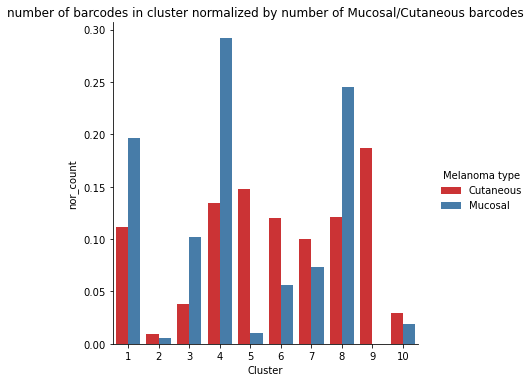

In [38]:
cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal

print('Normalized by number of barcodes in group (Mucosal/Cutaneous):')

count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')
    
print()
print(ranksums(cutaneous_nor, mucosal_nor))
print(wilcoxon(cutaneous_nor, mucosal_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=3.779644730092272, pvalue=0.00015705228423075119)
WilcoxonResult(statistic=0.0, pvalue=0.001953125)


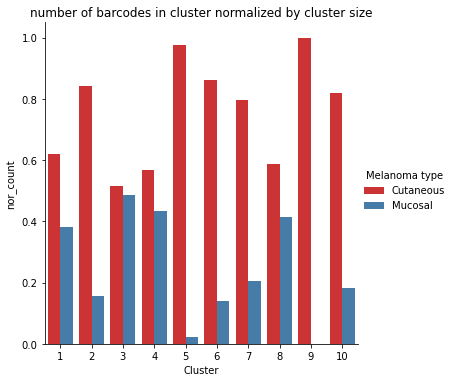

In [39]:
cutaneous_nor = cutaneous_counts/(cutaneous_counts + mucosal_counts) #n_cutaneous
mucosal_nor = mucosal_counts/(cutaneous_counts + mucosal_counts) #n_mucosal


    
df_nor_count = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(cutaneous_nor, mucosal_nor))
print(wilcoxon(cutaneous_nor, mucosal_nor))

# 2.1. patient fraction over clusters - ranksum test

In [40]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster']).drop(columns=['index'])

sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Melanoma type'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

See how many samples (Cutaneous/Mucosal) have cells in each cluster:

In [41]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster']).drop(columns=['index'])

sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Melanoma type'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

Add zero fraction samples:

With corrected pvals!


<Figure size 480x240 with 0 Axes>

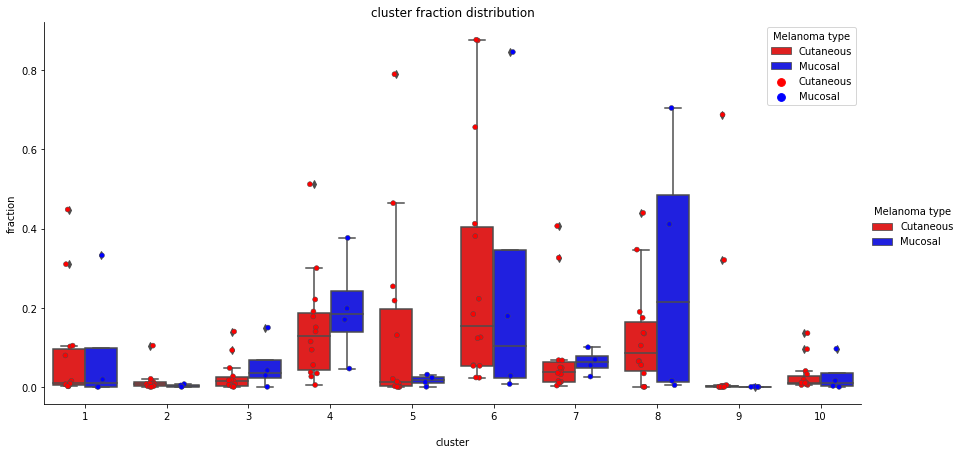

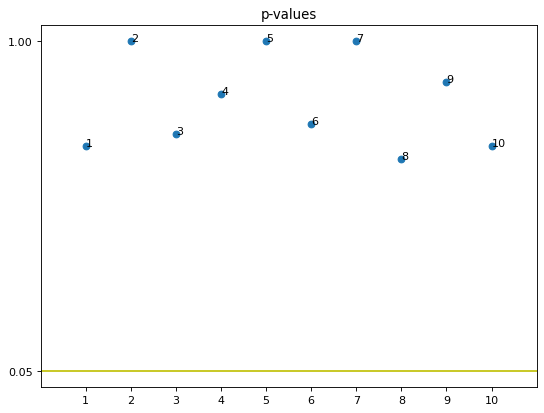

In [44]:
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Melanoma type']!='other'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = cutaneous_samples + mucosal_samples
dic_response = {ss:'Cutaneous' for ss in cutaneous_samples}
dic_response.update({ss:'Mucosal' for ss in mucosal_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, dic_response[sample], 0, 0]], columns=full_sample_fractions_df.columns))
    


pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    cutaneous_fractions = cluster_df[cluster_df['Melanoma type'] == 'Cutaneous']['fraction'].values
    mucosal_fractions = cluster_df[cluster_df['Melanoma type'] == 'Mucosal']['fraction'].values
    res = ranksums(cutaneous_fractions, mucosal_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

sns.reset_orig()
plt.figure(figsize=(6, 3), dpi=80)
full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="box", x='cluster', y='fraction', hue='Melanoma type', data=full_sample_fractions_df, palette={'Cutaneous':'r', 'Mucosal':'b'},height=6, aspect=2.0).set(title="cluster fraction distribution")
sns.stripplot(x='cluster', y='fraction', hue='Melanoma type', data=full_sample_fractions_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'Cutaneous':'r', 'Mucosal':'b'});

print_pvals(corrected_pvals, len(set(sample_fractions_df["Cluster"])))

In [17]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test.png'), dpi = 150)

In [18]:
# cluster_idx = 8

# pd.set_option('display.max_rows', None)
# display(full_sample_fractions_df[full_sample_fractions_df['Cluster']==cluster_idx].sort_values('fraction'))#['Response'].tolist()
# pd.set_option('display.max_rows', 10)

# 2.2 clusters analysis - Fisher exact's test

With corrected pvals!


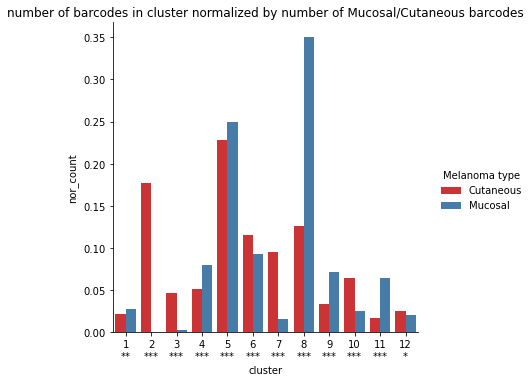

In [19]:
n_cells_in_group_df = df.groupby(['Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Cutaneous')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Cutaneous']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Mucosal')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Mucosal']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    pvals.append([cluster_idx, pvalue])
pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T


cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal
count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
count_df['cluster'] = count_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
ax = sns.catplot(kind="bar", x='cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')
# print_pvals(pvals, len(clusters))

In [20]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'clustering_fisher_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')

# ax.savefig(join(OUTPUT_PATH, 'clustering_fisher_test.png'), dpi = 150)

# GEP

In [21]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'
selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '30'
N_PROG = 30
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [22]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
# keep only data of current patients in cohort
GEP_all_samples_df = df.copy()
df = df[df['sample'].isin(res_melanoma_clinical_data.index.tolist())]

df['Melanoma type'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])


Shows which programs are activity programs, displays the number of samples associated with each program.

In [23]:
activity_programs_df = GEP_all_samples_df.copy()


cell_usage_threshold = 0.2
sample_portion_threshold = 0.2
activity_programs_df.iloc[:,:N_PROG] = activity_programs_df.iloc[:,:N_PROG] > cell_usage_threshold

sample_counts_df = activity_programs_df.groupby('sample').sum().reset_index().set_index('sample')
samples_num_barcodes = pd.DataFrame(activity_programs_df.groupby('sample')['barcode'].count()).rename(columns={'barcode':'count'})  #.agg({'barcode': ['count']}).reset_index()
sample_fraction_df = sample_counts_df.div(samples_num_barcodes.loc[sample_counts_df.index]['count'], axis=0)

# sample_fraction_df
num_of_program_in_sample = sample_fraction_df > sample_portion_threshold

activity_programs_idx = np.array(num_of_program_in_sample.columns)[num_of_program_in_sample.sum()>1].astype(int)

print(f'Number of activity programs (more than 2 samples are associated): {len(activity_programs_idx)}')
print(f'Activity programs (more than 2 samples are associated): {activity_programs_idx}')

# num_of_program_in_sample.sum()

Number of activity programs (more than 2 samples are associated): 18
Activity programs (more than 2 samples are associated): [ 2  4  6  7 10 11 13 14 17 18 19 20 21 24 25 26 28 30]


# 3.1. GEP association with response - usages ranksum test

Per program, take all usage values of cells coming from cutaneous patients vs. mucosal patients, and perform Wilcoxon ranksum test.

With corrected pvals!!


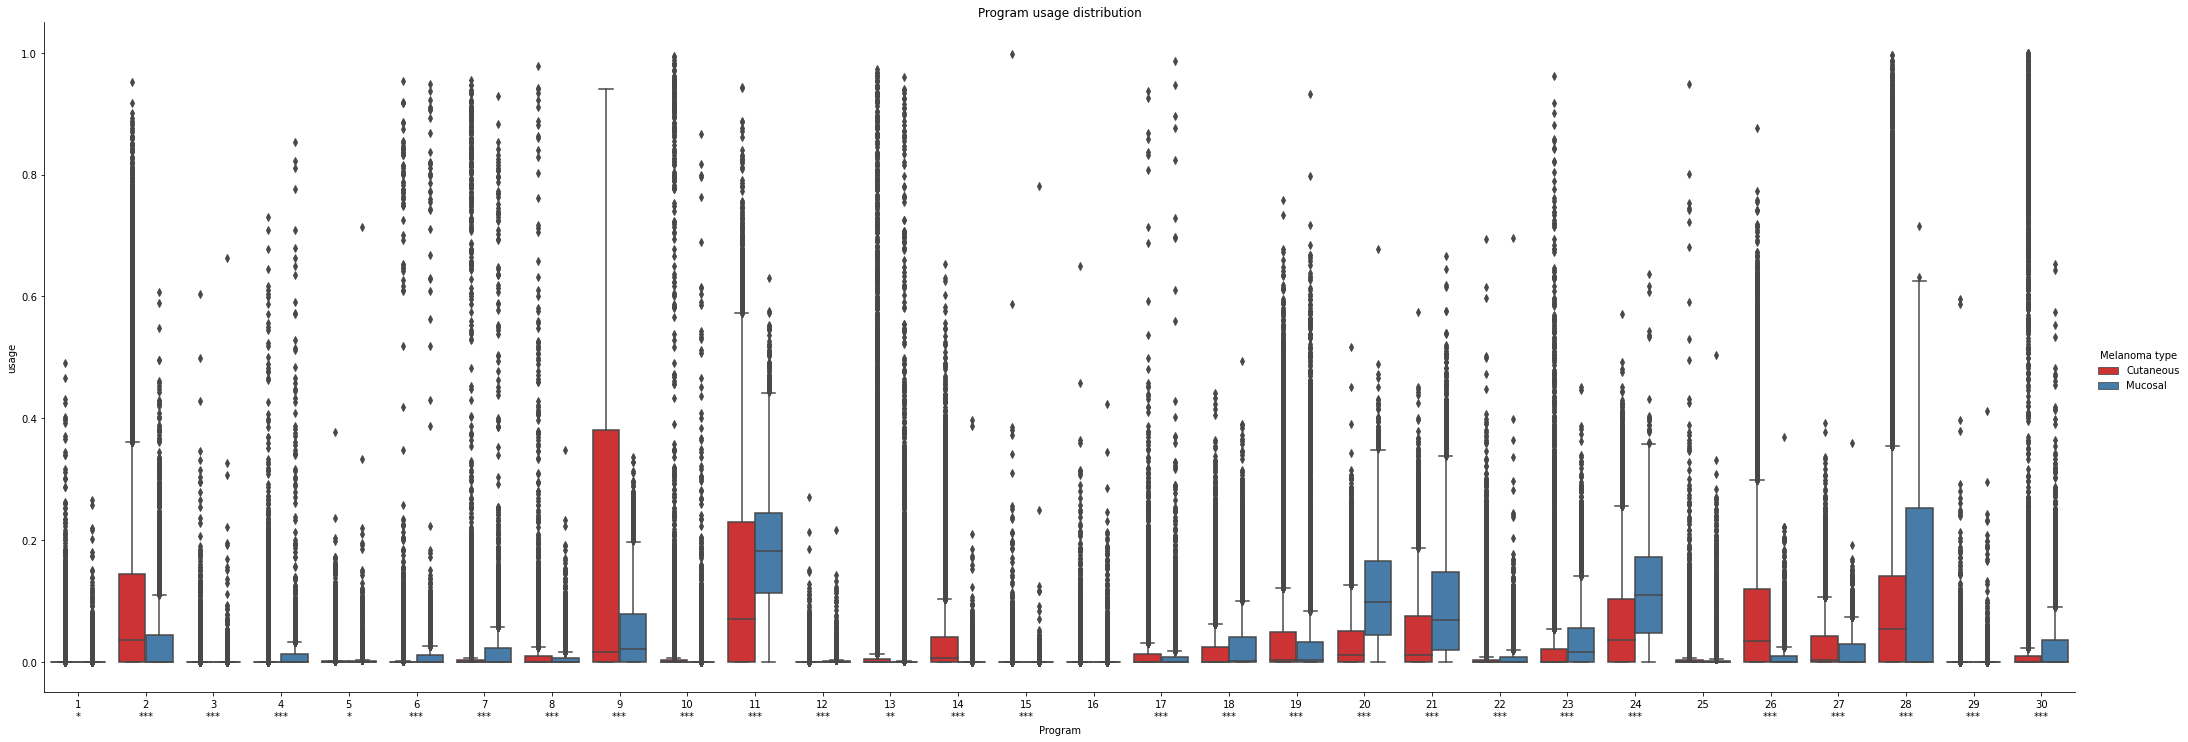

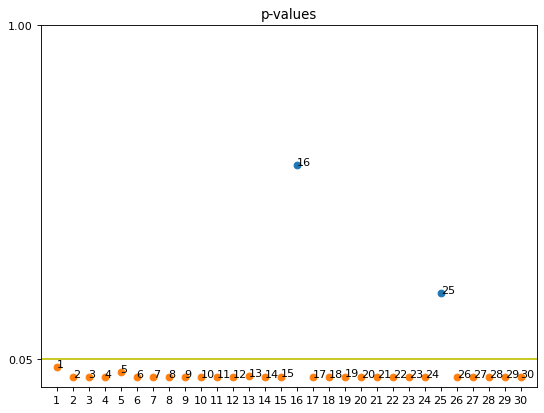

In [24]:
melt_fd = df.melt(id_vars=["sample","barcode", 'Melanoma type'], var_name="program", value_name="usage")
melt_fd = melt_fd[melt_fd['Melanoma type'].isin(['Cutaneous', 'Mucosal'])]

pvals = np.zeros([selected_K, 2])

for i in range(1, selected_K+1):
    pvals[i-1, 1] = ranksums(melt_fd[(melt_fd['Melanoma type'] == 'Cutaneous').values & (melt_fd.program == i).values].usage,
                         melt_fd[(melt_fd['Melanoma type'] == 'Mucosal').values & (melt_fd.program == i).values].usage)[1]
    pvals[i-1, 0] = i

# Correct pvals
print(f'With corrected pvals!!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

def get_pval_asterisks(x ,p_value_dic):
    return str(x)+'\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if p_value_dic[x] < sig])
melt_fd['Program'] = melt_fd['program'].apply(lambda x: get_pval_asterisks(x, dict(corrected_pvals)))

sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='usage', hue='Melanoma type', data=melt_fd, palette="Set1",height=10, aspect=2.9).set(title="Program usage distribution")

print_pvals(corrected_pvals, N_PROG)

In [25]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'GEP_usages_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')

# ax.savefig(join(OUTPUT_PATH, 'GEP_usages_ranksum_test.png'), dpi = 150)

### Only activity programs

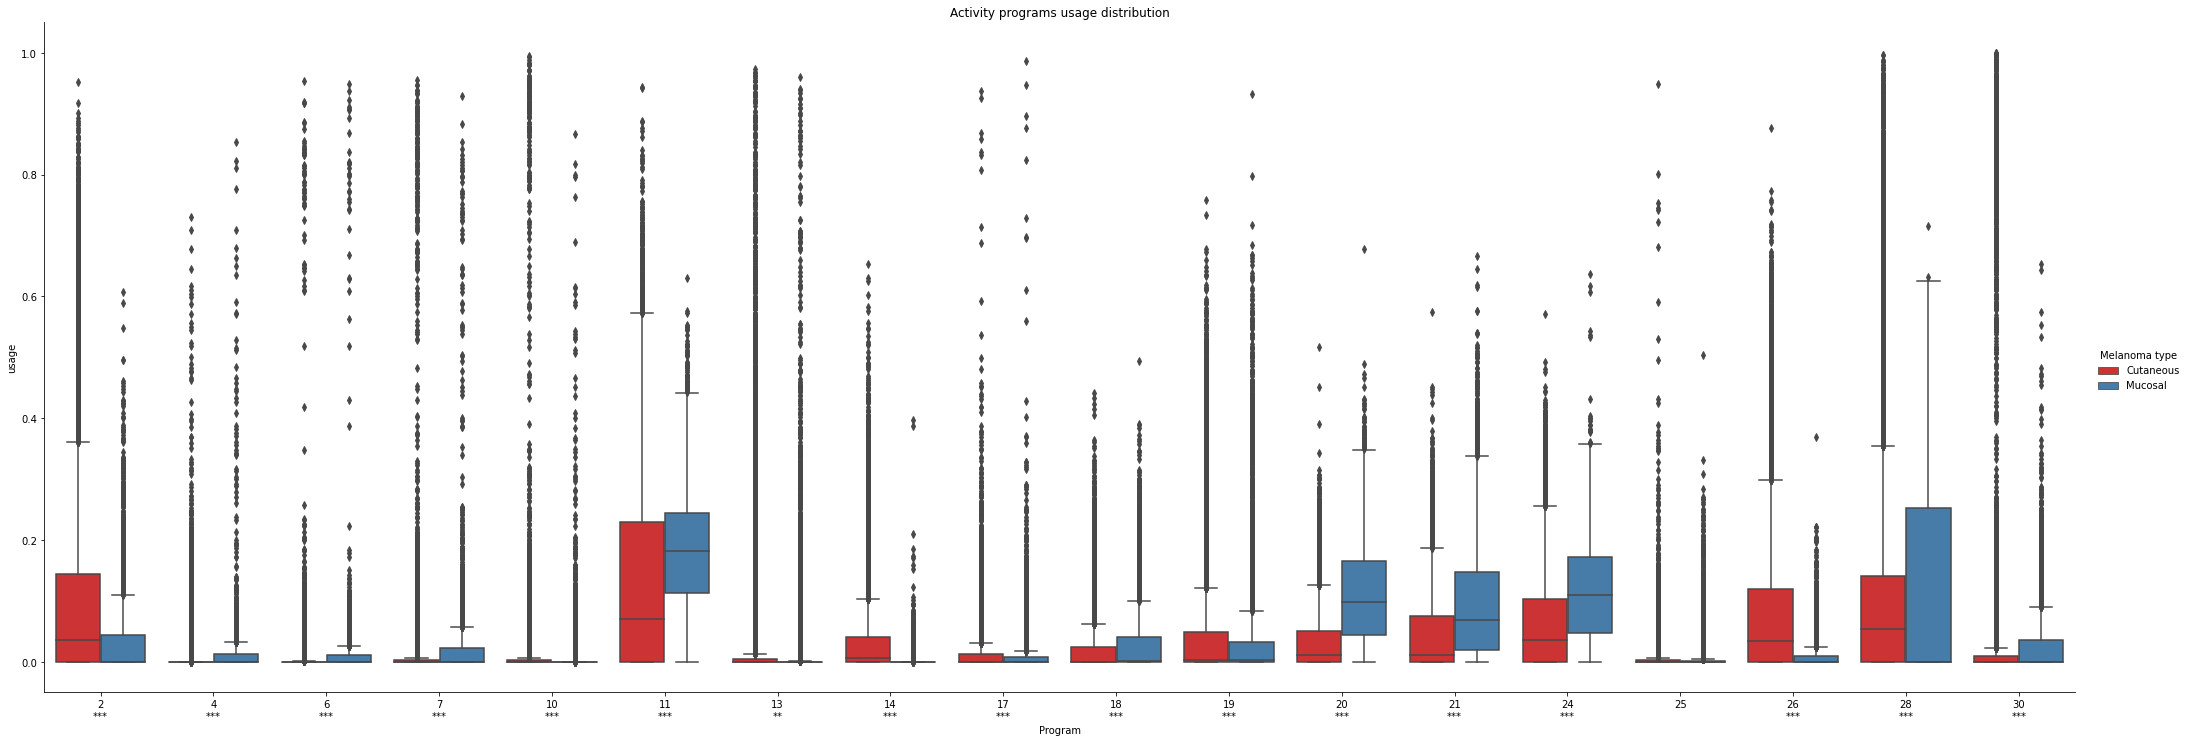

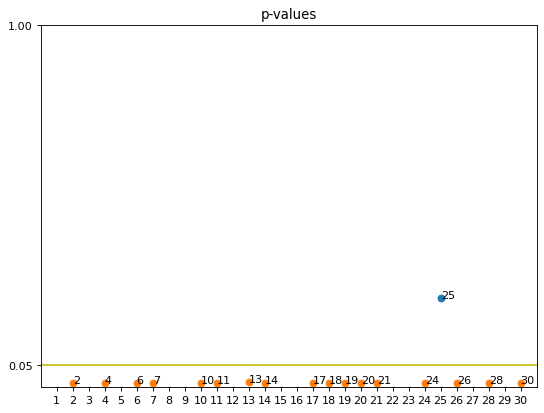

In [26]:
activity_melt_fd = melt_fd[melt_fd.program.isin(activity_programs_idx)]
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='usage', hue='Melanoma type', data=activity_melt_fd, palette="Set1",height=10, aspect=2.9).set(title="Activity programs usage distribution")

int_prog_indxes = activity_programs_idx-1
print_pvals(corrected_pvals[int_prog_indxes], N_PROG)

In [27]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# ax.savefig(join(OUTPUT_PATH, 'Activity_GEP_usages_ranksum_test.png'), dpi = 150)

# 4. GEP association with response (2) - each cell is associated with one program
### 4.1. Fraction test

Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between cutaneous and mucosal patients.


###### Loads usages:

In [28]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'
selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
N_PROG = 30
RUN_RANGE = '30'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [29]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
# keep only data of current patients in cohort
df = df[df['sample'].isin(res_melanoma_clinical_data.index.tolist())]
df['Melanoma type'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

df_cutaneous = df[df['Melanoma type']=='Cutaneous']
df_mucosal = df[df['Melanoma type']=='Mucosal']

##### Assign each cell one program based on the maximal usage value.

In [30]:
cutaneous_high_prog = np.argmax(df_cutaneous[list(range(1,N_PROG+1))].values, axis=1)+1
mucosal_high_prog = np.argmax(df_mucosal[list(range(1,N_PROG+1))].values, axis=1)+1

df_cutaneous['associated program'] = cutaneous_high_prog
df_mucosal['associated program'] = mucosal_high_prog

<ipython-input-30-46b1a0bc80aa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutaneous['associated program'] = cutaneous_high_prog
<ipython-input-30-46b1a0bc80aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mucosal['associated program'] = mucosal_high_prog


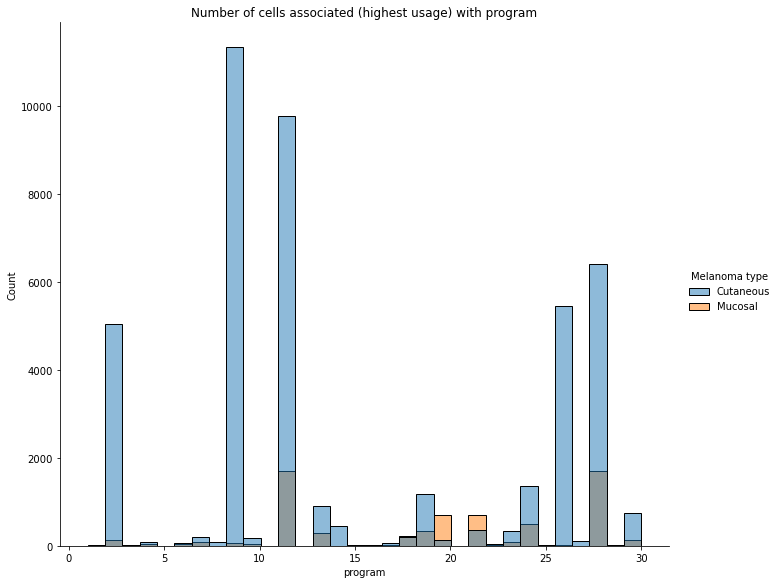

In [31]:
sns.reset_orig() 
ddd = pd.DataFrame(np.concatenate([cutaneous_high_prog, mucosal_high_prog]), columns=['program'])
ddd['Melanoma type'] = ['Cutaneous']*len(cutaneous_high_prog) + ['Mucosal']*len(mucosal_high_prog)
sns.displot(data=ddd, x='program', hue='Melanoma type', common_norm=False,height=8, aspect=1.2).set(title=f'Number of cells associated (highest usage) with program');

Conduct ranksum test:

In [32]:
cutaneous_associated_program_count_df = pd.DataFrame(df_cutaneous.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
cutaneous_samples = cutaneous_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in cutaneous_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  cutaneous_associated_program_count_df[cutaneous_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_cutaneous_patients_usage = {p: [samples_dic[sample][p]  for sample in cutaneous_samples] for p in range(1, selected_K+1)}



mucosal_associated_program_count_df = pd.DataFrame(df_mucosal.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
mucosal_samples = mucosal_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in mucosal_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  mucosal_associated_program_count_df[mucosal_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_mucosal_patients_usage = {p: [samples_dic[sample][p]  for sample in mucosal_samples] for p in range(1, selected_K+1)}

With corrected pvals!!


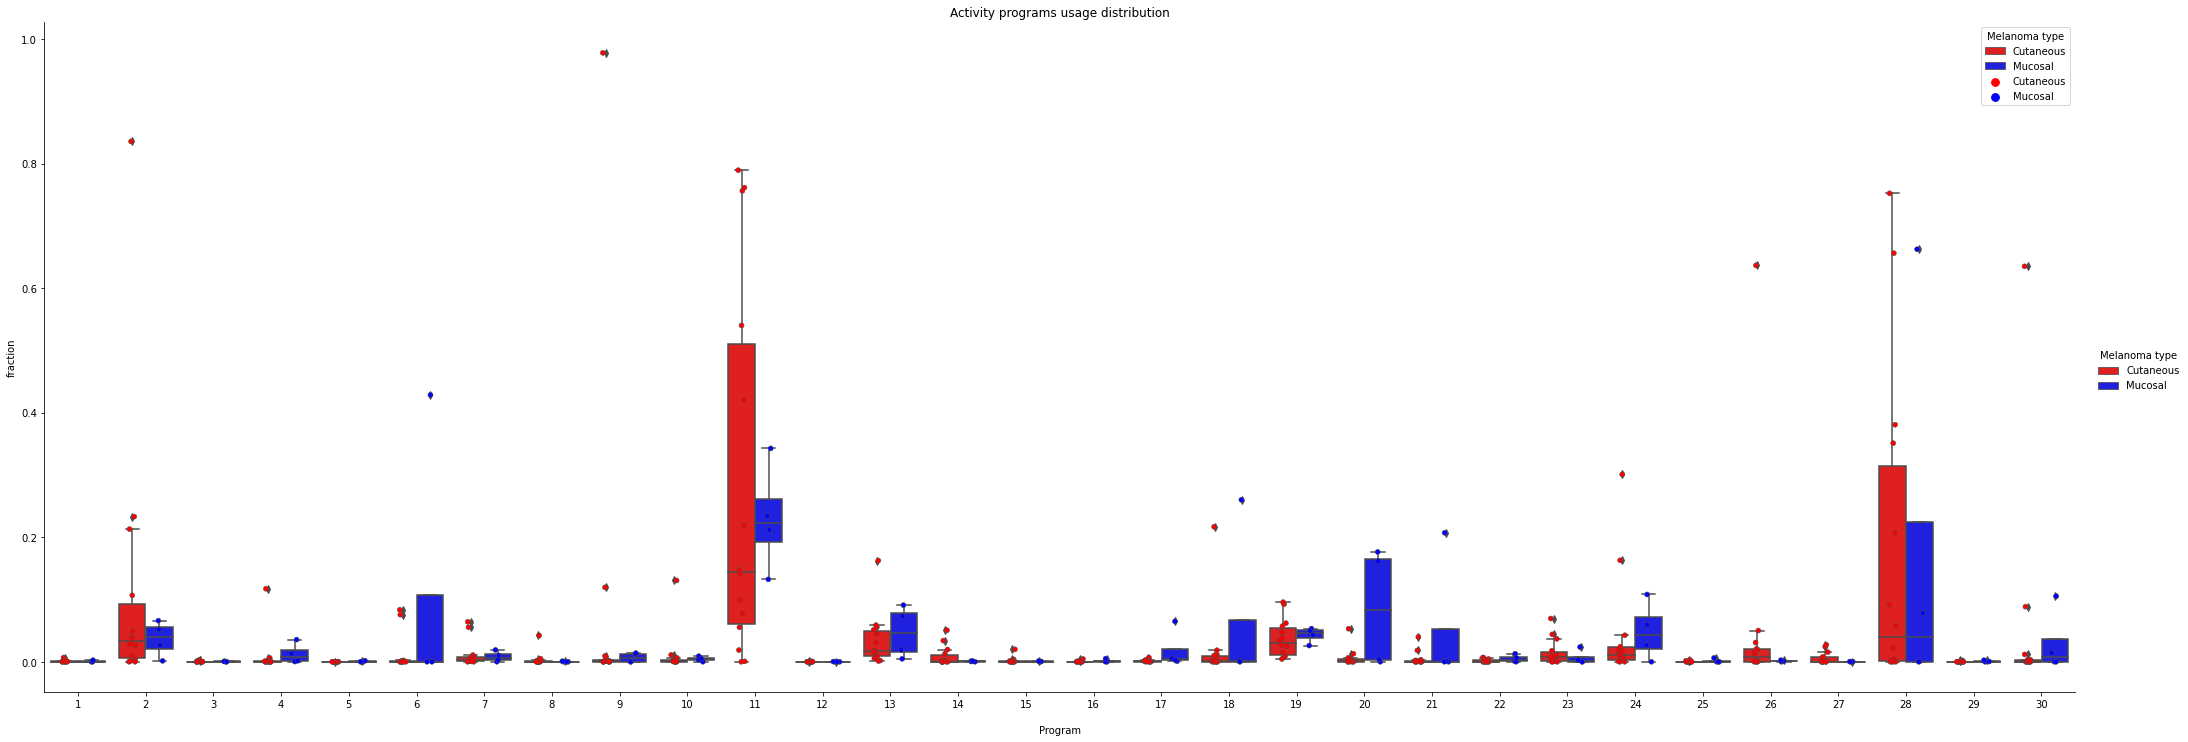

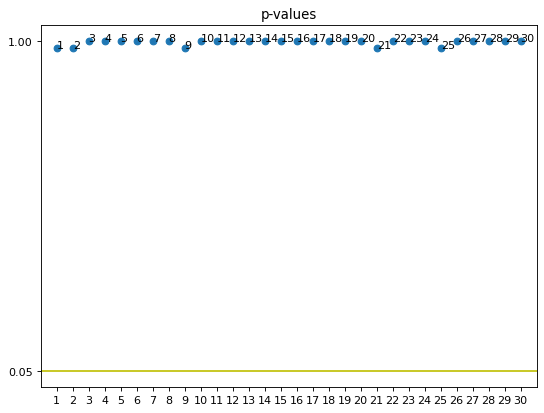

In [33]:
pvals = np.zeros([selected_K, 2])
for i in range(1, selected_K+1):
    pvals[i-1, 1] = ranksums(programs_mucosal_patients_usage[i], programs_cutaneous_patients_usage[i])[1]
    pvals[i-1, 0] = i

# Correct pvals
print(f'With corrected pvals!!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

programs_m_patients_df = pd.DataFrame(programs_mucosal_patients_usage)
programs_m_patients_df['Melanoma type'] = 'Mucosal'
programs_c_patients_df = pd.DataFrame(programs_cutaneous_patients_usage)
programs_c_patients_df['Melanoma type'] = 'Cutaneous'

fraction_df = programs_c_patients_df.melt(id_vars=['Melanoma type'], var_name="program", value_name="fraction").append(programs_m_patients_df.melt(id_vars=['Melanoma type'], var_name="program", value_name="fraction"))

sns.reset_orig()
def get_pval_asterisks(x ,p_value_dic):
    return str(x)+'\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if p_value_dic[x] < sig])
fraction_df['Program'] = fraction_df['program'].apply(lambda x: get_pval_asterisks(x, dict(corrected_pvals)))
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Melanoma type', data=fraction_df, palette={'Cutaneous':'r', 'Mucosal':'b'},height=10, aspect=2.9).set(title="Activity programs usage distribution")
sns.stripplot(x='Program', y='fraction', hue='Melanoma type', data=fraction_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'Cutaneous':'r', 'Mucosal':'b'});
print_pvals(corrected_pvals, N_PROG)

In [34]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'GEP_fraction_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')

# ax.savefig(join(OUTPUT_PATH, 'GEP_fraction_ranksum_test.png'), dpi = 150)

Specify program and see the fraction of Cutaneous/Mucosal sorted:

In [35]:
# program_idx = 13

# patient_fractions = sorted([[x, 'Cutaneous'] for x in programs_cutaneous_patients_usage[program_idx]] + [[x, 'Mucosal'] for x in programs_mucosal_patients_usage[program_idx]])

# sns.reset_orig() # reset size of figure
# boxplot_df = pd.DataFrame(patient_fractions, columns=['prog_fraction', 'Melanoma type'])
# sns.catplot(x='Melanoma type', y="prog_fraction", data=boxplot_df, kind="box",height=5, aspect=1.2);


# # print([x[1] for x in patient_fractions])
# patient_fractions

### Present only activity programs:

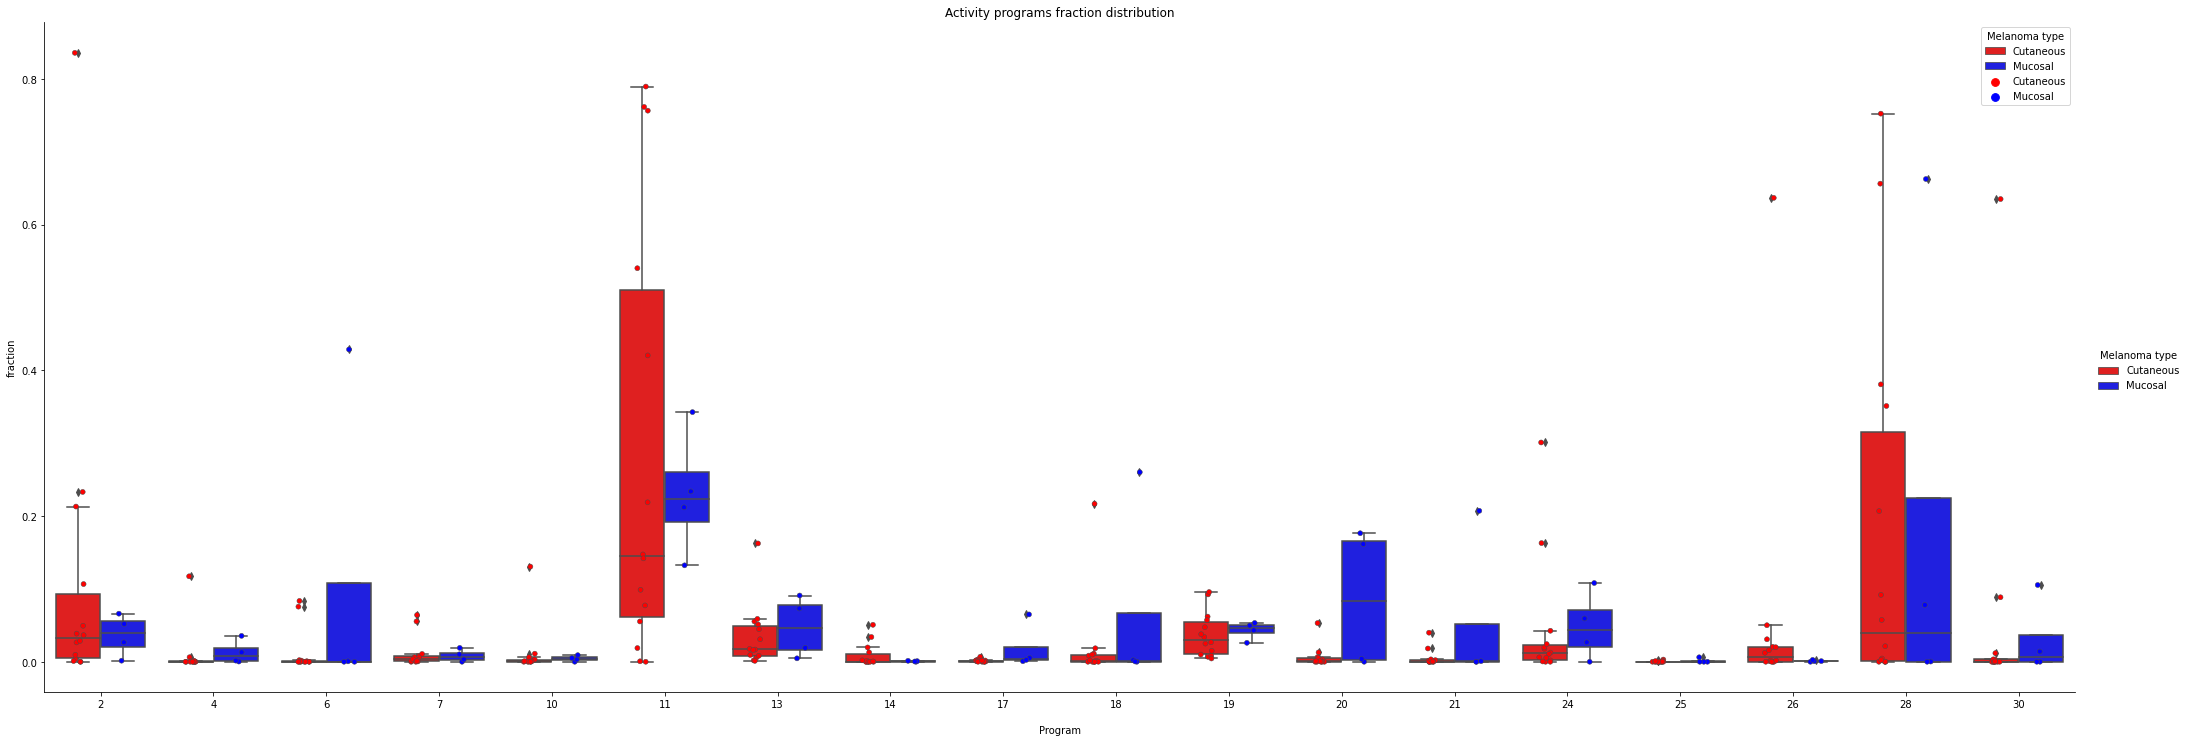

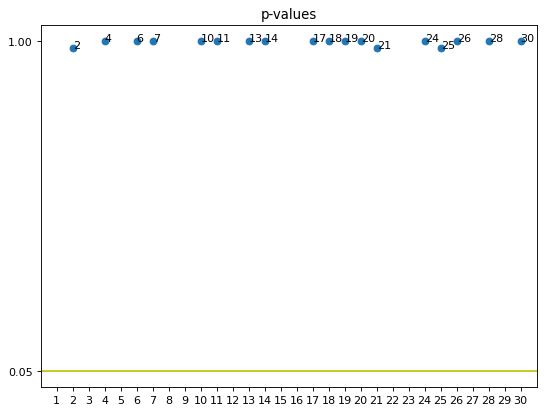

In [36]:
activity_fraction_df = fraction_df[fraction_df.program.isin(activity_programs_idx)]
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Melanoma type', data=activity_fraction_df, palette={'Cutaneous':'r', 'Mucosal':'b'},height=10, aspect=2.9).set(title="Activity programs fraction distribution")
sns.stripplot(x='Program', y='fraction', hue='Melanoma type', data=activity_fraction_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'Cutaneous':'r', 'Mucosal':'b'});

int_prog_indxes = activity_programs_idx-1
print_pvals(corrected_pvals[int_prog_indxes], N_PROG)

In [37]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# ax.savefig(join(OUTPUT_PATH, 'Activity_GEP_fraction_ranksum_test.png'), dpi = 150)

## 4.2. GEP - Fisher exact's test

With corrected pvals!


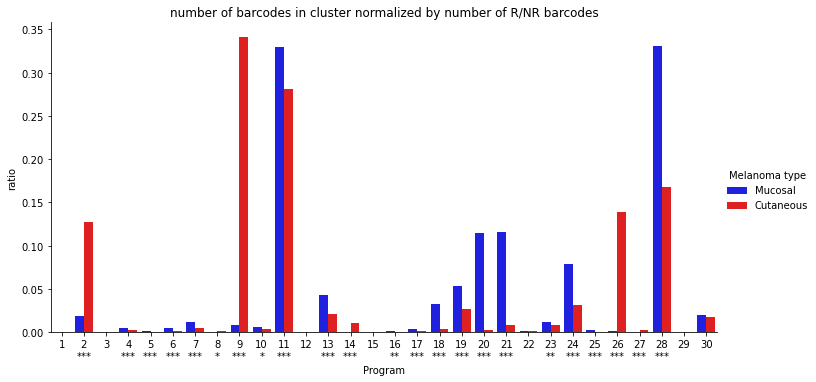

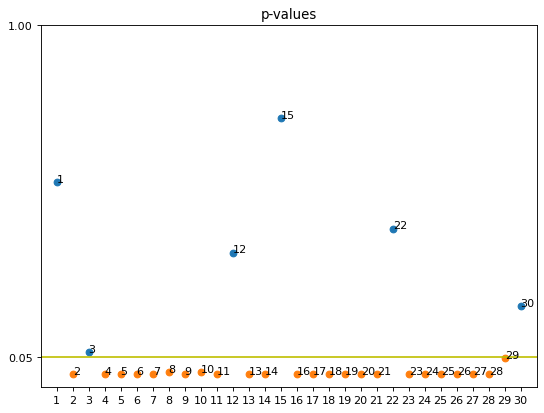

In [38]:
pvals = []
ratios = []
for curr_prog_idx in range(1, N_PROG+1):
    n_cells_g1_in_prog = len(df_mucosal[df_mucosal['associated program']==curr_prog_idx])
    n_cells_g1_not_in_prog = len(df_mucosal) - n_cells_g1_in_prog
    
    n_cells_g2_in_prog = len(df_cutaneous[df_cutaneous['associated program']==curr_prog_idx])
    n_cells_g2_not_in_prog = len(df_cutaneous) - n_cells_g2_in_prog
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_prog, n_cells_g2_in_prog],[n_cells_g1_not_in_prog, n_cells_g2_not_in_prog]])
    pvals.append([curr_prog_idx, pvalue])
    ratios.append([curr_prog_idx, n_cells_g1_in_prog / n_cells_g1_not_in_prog, n_cells_g2_in_prog / n_cells_g2_not_in_prog])

pvals = np.array(pvals)

# Correct pvals
print('With corrected pvals!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

ratios_df = pd.DataFrame(ratios, columns=['program', 'Mucosal', 'Cutaneous'])
ratios_df = ratios_df.melt(id_vars=["program"], var_name='Melanoma type', value_name="ratio")

def get_pval_asterisks(x ,p_value_dic):
    return str(x)+'\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if p_value_dic[x] < sig])
ratios_df['Program'] = ratios_df['program'].apply(lambda x: get_pval_asterisks(x, dict(corrected_pvals)))
sns.reset_orig() # reset size of figure
ax = sns.catplot(kind="bar", x='Program', y='ratio', hue='Melanoma type', data=ratios_df, palette={'Cutaneous':'r', 'Mucosal':'b'}, height=5, aspect=2).set(title='number of barcodes in cluster normalized by number of R/NR barcodes')

print_pvals(pvals, N_PROG)

In [39]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'GEP_ratios_fisher_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'GEP_ratios_fisher_test.png'), dpi = 150)

### only activity programs

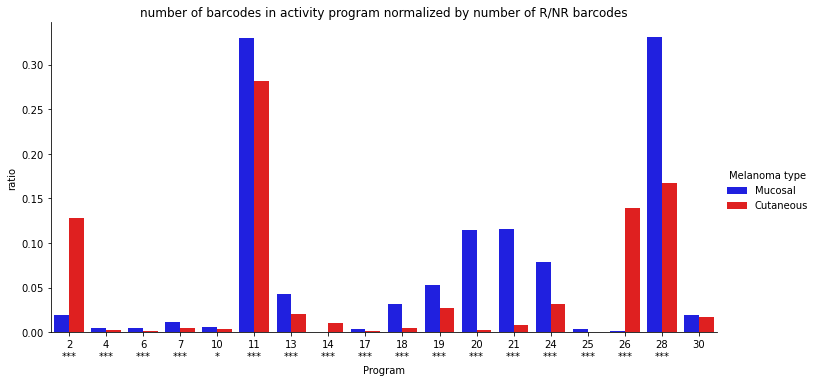

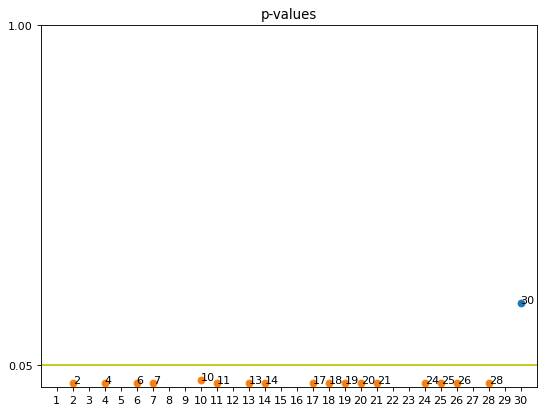

In [40]:
sns.reset_orig() # reset size of figure
ax = sns.catplot(kind="bar", x='Program', y='ratio', hue='Melanoma type', data=ratios_df[ratios_df.program.isin(activity_programs_idx)], palette={'Cutaneous':'r', 'Mucosal':'b'}, height=5, aspect=2).set(title='number of barcodes in activity program normalized by number of R/NR barcodes')

int_prog_indxes = activity_programs_idx-1
act_pvals = corrected_pvals[int_prog_indxes]
print_pvals(act_pvals, N_PROG)

In [41]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# ax.savefig(join(OUTPUT_PATH, 'Activity_GEP_ratios_fisher_test.png'), dpi = 150)

# Debug

In [112]:
import scipy.stats as stats
A = 100
a = 900

B = 90
b = 700
oddsratio, pvalue = stats.fisher_exact([[A, B],
                                        [a, b]])
oddsratio, pvalue

In [48]:
cluster_idx = 4

d1 = df.groupby(['Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
d2 = df.groupby(['Cluster', 'Melanoma type']).agg(count=('Barcode', 'count')).reset_index()

A = d2[(d2.Cluster == cluster_idx) & (d2['Melanoma type']=='Cutaneous')]['count'].values[0]
a = d1[d1['Melanoma type']=='Cutaneous']['count'].values[0] - A
B = d2[(d2.Cluster == cluster_idx) & (d2['Melanoma type']=='Mucosal')]['count'].values[0]
b = d1[d1['Melanoma type']=='Mucosal']['count'].values[0] - B
stats.fisher_exact([[A, B],[a, b]])

(0.6139991093400169, 3.084609550576258e-17)

In [45]:
A, a, B, b

(331, 11841, 233, 8242)

In [122]:
normalized_usage_matrix.values[:1000].shape
threshold = 0.1
sort_dic(Counter(np.sum(normalized_usage_matrix.values[:200]>threshold, axis=1)))

{1: 3, 2: 45, 3: 111, 4: 36, 5: 5}

In [3]:
df = get_clinical_subdata(n_R_muc=0, n_NR_muc=4, n_R_cut=0, n_NR_cut=0, ICI=True, only_metastasis_sample=True, therapy_translator=therapy_IPI_transletror)
# get_clinical_table_size(response='R', melanoma_type=['Cutaneous'], ICI=True, only_metastasis_sample=True, therapy_translator=therapy_IPI_transletror)
df

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_OCT_unportected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx
There are no enough samples as you requested! valid the number that you ask!


In [34]:
# n_samples = 71
# pd.set_option('display.max_rows', None)

# melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
# # melanoma_clinical_data['Therapy after biopsy'].iloc[:46]

# def translate(x):
#     if not x or str(x)=='nan':
#         return 'nothing'
#     x = str(x).lower()
#     if 'ipi' in x or 'pembro' in x or 'pembo' in x or 'nivo' in x or 'apd' in x or 'pd1' in x:
#         return 'ICI'
    
#     elif 'enco' in x or 'd+t' in x:
#         return 'other therapy'
    
#     elif 'radiation' in x:
#         return 'other therapy'
    
#     elif 'carbo' in x or 'imatinib' in x or 'tmz' in x or 'tvec' in x or 'cdk4/6' in x :
#         return 'other immune therapy'
    
#     elif 'surgical ' in x or 'surgery ' in x or 'neodajuvant' in x:
#         return 'other therapy'
       
#     else:
#         return x
    
# # Counter(melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:46])
# x = melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:n_samples].apply(lambda x: translate(x))
# y = melanoma_clinical_data['Therapy after biopsy'].iloc[:n_samples].apply(lambda x: translate(x))
# z = melanoma_clinical_data.iloc[:n_samples]['Patient id'].tolist()
# ICI_df = pd.DataFrame(list(zip(z, x,y, (x == 'ICI') | (y == 'ICI'))), columns=['id', 'prior', 'after', 'ICI'])
# # melanoma_clinical_data
# ICI_df

In [78]:
sum(ICI_df['ICI'])

53

In [65]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)


In [69]:

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:71][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
# melanoma_clinical_data


In [70]:
labels_mapping['R '] = 'R'

In [71]:
# adds CRITERIA response into clinical df
# melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')


In [32]:


# Melanoma type
# res_melanoma_clinical_data = res_melanoma_clinical_data[(res_melanoma_clinical_data['Melanoma type']=='Cutaneous') | (res_melanoma_clinical_data['Melanoma type']=='Mucosal ')]
# melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal ', 'Uveal': 'other', 'UN primary': 'other', 'Acral': 'other', 'Unknown': 'other', '??':'other'}
# res_melanoma_clinical_data['Melanoma type'] = res_melanoma_clinical_data['Melanoma type'].apply(lambda rr: melanoma_type_translate[rr])
# res_melanoma_clinical_data

In [85]:
res_melanoma_clinical_data['Melanoma type'].value_counts()

Cutaneous    49
other        14
Mucosal       8
Name: Melanoma type, dtype: int64

In [11]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

In [33]:
# def translate(n):
#     if n in ['Cutaneous', 'Mucosal ']:
#         return n
#     else: return 'other'
# melanoma_clinical_data3 = melanoma_clinical_data#[melanoma_clinical_data['Melanoma type'].isin(['Cutaneous', 'Mucosal '])]
# melanoma_clinical_data3 = melanoma_clinical_data
# melanoma_clinical_data3['Melanoma type'] = melanoma_clinical_data3['Melanoma type'].map(lambda x: translate(x))

# melanoma_clinical_data.groupby(['Melanoma type', 'response']).count()
# melanoma_clinical_data3.groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['Clinical response']).rename(columns={'Patient id': 'number of samples'})
# # set(melanoma_clinical_data['Melanoma type'].tolist())

In [3]:
# melanoma_clinical_data2 = melanoma_clinical_data
# melanoma_clinical_data2

In [36]:

indices = sorted((np.random.rand(1000)*cohort.number_of_cells).astype(int))
# indices

In [37]:
path = r'/storage/md_keren/shitay/garbage/1000_rand_cells.pkl'
pickle.dump(cohort[indices], open(path, 'wb'))

With corrected pvals!
cluster = 1,	ratio = 1.011,	diff = 0.0003,	pval<0.05= False,	condition = False
cluster = 2,	ratio = 4553.74,	diff = 0.5418,	pval<0.05= True,	condition = True
cluster = 3,	ratio = 5.97,	diff = 0.0141,	pval<0.05= True,	condition = True
cluster = 4,	ratio = 1.629,	diff = 0.0335,	pval<0.05= True,	condition = True
cluster = 5,	ratio = 2.186,	diff = 0.1798,	pval<0.05= True,	condition = True
cluster = 6,	ratio = 2.571,	diff = 0.1617,	pval<0.05= True,	condition = True
cluster = 7,	ratio = 2.786,	diff = 0.0291,	pval<0.05= True,	condition = True
cluster = 8,	ratio = 19.4,	diff = 0.5112,	pval<0.05= True,	condition = True
cluster = 9,	ratio = 1.472,	diff = 0.0248,	pval<0.05= True,	condition = False
cluster = 10,	ratio = 1.822,	diff = 0.0208,	pval<0.05= True,	condition = True
cluster = 11,	ratio = 4.881,	diff = 0.0546,	pval<0.05= True,	condition = True
cluster = 12,	ratio = 1.732,	diff = 0.0153,	pval<0.05= True,	condition = True


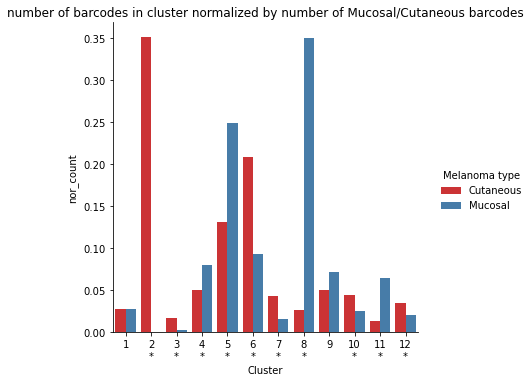

In [31]:
n_cells_in_group_df = df.groupby(['Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
n_cells_in_cluster_df = df.groupby(['Cluster', 'Melanoma type']).agg(count=('Barcode', 'count')).reset_index()
pvals = []
ratios = []
diffs = []
for cluster_idx in sorted(df['Cluster'].unique().tolist()):
    n_cells_g1_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Cutaneous')]['count'].values,np.array([0])))[0]
    n_cells_g1_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Cutaneous']['count'].values[0] - n_cells_g1_in_cluster
    
    n_cells_g2_in_cluster = np.concatenate((n_cells_in_cluster_df[(n_cells_in_cluster_df.Cluster == cluster_idx) & (n_cells_in_cluster_df['Melanoma type']=='Mucosal')]['count'].values,np.array([0])))[0]
    n_cells_g2_not_in_cluster = n_cells_in_group_df[n_cells_in_group_df['Melanoma type']=='Mucosal']['count'].values[0] - n_cells_g2_in_cluster
    oddsratio, pvalue = stats.fisher_exact([[n_cells_g1_in_cluster, n_cells_g2_in_cluster],[n_cells_g1_not_in_cluster, n_cells_g2_not_in_cluster]])
    g1_r = (n_cells_g1_in_cluster / n_cells_g1_not_in_cluster) + 0.000001
    g2_r = (n_cells_g2_in_cluster / n_cells_g2_not_in_cluster) + 0.000001
    diff = abs(g1_r - g2_r)
    
    ratio = abs(max(g1_r, g2_r) / min(g1_r, g2_r))

    condition = pvalue < 0.05 and (ratio > 1.5 or diff > 0.1)
    
    pvals.append(pvalue)
    ratios.append(ratio)
    diffs.append(diff)
#     print(f'cluster = {cluster_idx},\tratio = {round(ratio,3)},\tdiff = {round(diff,4)},\tpvalue = {round(pvalue,4)},\tconidtion = {condition}')
pvals = np.array(pvals)
ratios = np.array(ratios)
diffs = np.array(diffs)

# Correct pvals
print('With corrected pvals!')
pvals = multipletests_fdr(pvals)[1] < 0.05
condition = pvals & (ratios > 1.5) | (diffs > 0.1)
tr_lbl = {True: '*', False:''}

for i in sorted(df['Cluster'].unique().tolist()):
    print(f'cluster = {i},\tratio = {round(ratios[i-1],3)},\tdiff = {round(diffs[i-1],4)},\tpval<0.05= {pvals[i-1]},\tcondition = {condition[i-1]}')


cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal
# print('Normalized by number of barcodes in group (Mucosal/Cutaneous):')
count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
count_df['Cluster'] = count_df['Cluster'].apply(lambda x: str(x)+'\n'+tr_lbl[condition[x-1]])
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')

In [80]:
# def print_num(n):
#     if n==0:
#         return
#     print(n)
#     print_num(n-1)